In [8]:
import torch
print(torch.cuda.is_available())

True


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - accuracy: 0.6916 - loss: 0.6937 - val_accuracy: 0.6754 - val_loss: 0.7013
Epoch 2/3
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - accuracy: 0.8586 - loss: 0.3621 - val_accuracy: 0.8339 - val_loss: 0.3588
Epoch 3/3
5024/5024 ━━━━━━━━━━━━━━━━━━━━ 37s 4ms/step - accuracy: 0.8924 - loss: 0.2664 - val_accuracy: 0.8619 - val_loss: 0.2600
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
               precision    recall  f1-score   support

        Hate       0.80      0.78      0.79      4260
     Neutral       0.19      0.10      0.13       578
    Not Hate       0.85      0.90      0.87      7176

    accuracy                           0.82     12014
   macro avg       0.62      0.59      0.60     12014
weighted avg       0.80      0.82      0.81     12014

Accuracy: 81.74 %
Weighted F1 Score: 80.84 %


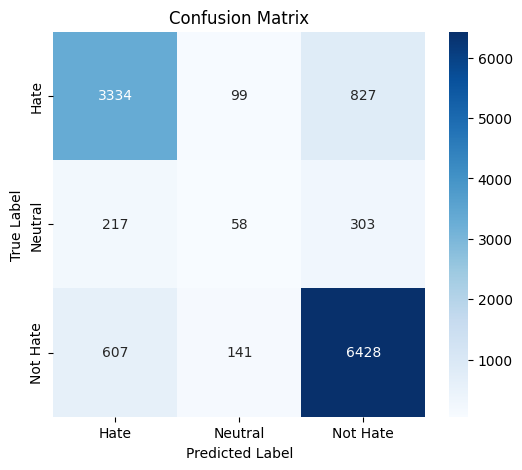

In [9]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# تحميل البيانات
df = pd.read_csv("/content/sample_data/CompanyReviews.csv")
X_raw = df['review_description'].astype(str)
y_raw = df['rating'].map({-1: 0, 0: 1, 1: 2})  # تصنيف إلى 3 فئات

# تنظيف النصوص
stop_words = set(stopwords.words("arabic")) - {"لا"}

def clean_text(text):
    text = re.sub(r'[\u064B-\u0652]', '', text)
    text = re.sub(r'(\d+:\d+|\d+)', r' \1 ', text)
    text = re.sub(r'[^\w\s\u0600-\u06FF]', '', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)
    text = re.sub(r'\s+', ' ', text)
    text = ' '.join([w for w in text.strip().split() if w not in stop_words])
    return text

X_clean = X_raw.apply(clean_text)

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_clean, y_raw, test_size=0.3, stratify=y_raw, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train_text).toarray()
X_test_vect = vectorizer.transform(X_test_text).toarray()

smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_vect, y_train)

model = Sequential()
model.add(Dense(512, input_dim=X_train_bal.shape[1], activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))  # ثلاث فئات

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(
    X_train_bal, y_train_bal,
    epochs=3,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

y_pred_probs = model.predict(X_test_vect)
y_pred = np.argmax(y_pred_probs, axis=1)

# التقييم
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Hate", "Neutral", "Not Hate"]))
print("Accuracy:", round(accuracy_score(y_test, y_pred) * 100, 2), "%")
print("Weighted F1 Score:", round(f1_score(y_test, y_pred, average='weighted') * 100, 2), "%")

# مصفوفة الالتباس
labels = ["Hate", "Neutral", "Not Hate"]
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
